## Load data

In [244]:
import os
import sys
import cv2
import torch
import fileinput

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from time import sleep
from copy import deepcopy
from tqdm.notebook import tqdm

from pillow_heif import register_heif_opener
register_heif_opener()

In [245]:
train_img_names = list(sorted(os.listdir('train')))
test_img_names = list(sorted(os.listdir('test')))

print(f'N train_img_names: {len(train_img_names)}')
print(f'N test_img_names: {len(test_img_names)}\n')

train_labels_df = pd.read_csv('train.csv', sep=';', index_col=None)
train_labels_df.head()

N train_img_names: 530
N test_img_names: 521



,image_name,distance
0,img_1596.jpg,4.88
1,img_1600.jpg,1.54
2,img_1601.jpg,3.68
3,img_1603.jpg,2.22
4,img_1605.jpg,3.73


## ANPR Recognition

In [246]:
def prepend_text(filename, text):
    with fileinput.input(filename, inplace=True) as file:
        for line in file:
            if file.isfirstline():
                print(text)
            print(line, end="")

In [247]:
if not os.path.isfile('weights.pt'):
    weights_url = 'https://archive.org/download/anpr_weights/weights.pt'
    os.system(f'wget {weights_url}')

if not os.path.isdir('yolov7'):
    yolov7_repo_url = 'https://github.com/WongKinYiu/yolov7'
    os.system(f'git clone {yolov7_repo_url}')
    
    # Fix import errors
    for file in ['yolov7/models/common.py', 'yolov7/models/experimental.py',
                 'yolov7/models/yolo.py', 'yolov7/utils/datasets.py']:
            prepend_text(file, "import sys\nsys.path.insert(0, './yolov7')")

In [248]:
from yolov7.models.experimental import attempt_load
from yolov7.utils.general import check_img_size
from yolov7.utils.torch_utils import select_device, TracedModel
from yolov7.utils.datasets import letterbox
from yolov7.utils.general import non_max_suppression, scale_coords
from yolov7.utils.plots import plot_one_box

In [250]:
def load_img(folder, img_name, crop=False):
    img = Image.open(os.path.join(folder, img_name))
    return img

In [251]:
weights = 'weights.pt'
image_size = 640
trace = True

anpr_model = attempt_load(weights)
stride = int(anpr_model.stride.max())
imgsz = check_img_size(image_size, s=stride)

if trace:
    anpr_model = TracedModel(anpr_model, img_size=image_size)

anpr_model.eval();

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [252]:
def detect_plate(img):
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)

    img = torch.from_numpy(img).float()
    img /= 255.0

    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    with torch.no_grad():
        pred = anpr_model(img, augment=True)[0]

    pred = non_max_suppression(pred, 0.25, 0.45, classes=0, agnostic=True)

    plate_detections = []
    det_confidences = []

    for i, det in enumerate(pred):
        if len(det) > 0:
            for *xyxy, conf, cls in reversed(det):
                coords = [position for position in (torch.tensor(xyxy).view(1, 4)).tolist()[0]]
                plate_detections.append(coords)
                det_confidences.append(conf.item())

    return plate_detections, det_confidences


def crop(image, coord):
    return image[int(coord[1]):int(coord[3]), int(coord[0]):int(coord[2])]

In [253]:
def process_img(source_image):
    img = np.array(source_image)
    img = letterbox(img, new_shape=640)[0]
    return img


def bbox_x_distance_to_center(bbox, img_size):
    img_x_center = img_size[1] // 2
    x0 = float(bbox[0])
    x1 = float(bbox[2])
    bbox_x_center = np.abs(x0 + x1) / 2
    return np.abs(bbox_x_center - img_x_center)


def filter_pn(detections):
    def get_shape_rate(det):
        return (det[3] - det[1]) / (det[2] - det[0])
    
    min_shape_rate = 0.1
    max_shape_rate = 0.5
    
    return [det for det in detections if min_shape_rate < get_shape_rate(det) < max_shape_rate]


def collect_data(folder, img_names, draw_bbox):
    data = []

    for i, img_name in tqdm(enumerate(img_names), total=len(img_names)):
        img = load_img(folder, img_name)
        img = process_img(img)
        img = np.array(img)
        
        plate_detections, _ = detect_plate(img)
        plate_detections = filter_pn(plate_detections)

        if len(plate_detections) > 0:
            plate_distances = [bbox_x_distance_to_center(det, img.shape) for det in plate_detections]
            central_detection_index = np.argmin(plate_distances)
            central_detection = plate_detections[central_detection_index]
            central_dist = plate_distances[central_detection_index]

            data.append([img_name] + central_detection + [central_dist])

            if draw_bbox:
                detected_image = deepcopy(img)

                for j, coords in enumerate(plate_detections):
                    plate_region = crop(img, coords)
                    color = [0, 255, 0] if j == central_detection_index else [255, 0, 0]
                    plot_one_box(coords, detected_image, color=color, line_thickness=2)

                print(f'\n{i:3} {img_name}')
                detected_image = Image.fromarray(detected_image)
                detected_image.thumbnail((640, 640))
                display(detected_image)
        else:
            print(f'Skip {img_name}!')

    return data

In [255]:
train_data = collect_data('train', train_img_names, draw_bbox=False)
train_data_df = pd.DataFrame(train_data, columns=[
    'image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'dist_to_img_center'
])

train_data_df = pd.merge(train_labels_df, train_data_df, how='right', on='image_name')  # right !!!

print(train_data_df.shape, '\n')
train_data_df.head()

(530, 7) 



,image_name,distance,x_min,y_min,x_max,y_max,dist_to_img_center
0,img_1596.jpg,4.88,298.081146,249.757065,331.676788,257.230896,5.121033
1,img_1600.jpg,1.54,274.941132,395.858215,388.316193,424.732483,11.628662
2,img_1601.jpg,3.68,296.848663,261.417969,341.544037,272.219177,0.803650
3,img_1603.jpg,2.22,280.478424,285.119354,356.873322,302.688934,1.324127
4,img_1605.jpg,3.73,301.993469,246.655518,347.841797,257.757568,4.917633


In [257]:
test_data = collect_data('test', test_img_names, draw_bbox=False)
test_data_df = pd.DataFrame(test_data, columns=[
    'image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'dist_to_img_center'
])

print(test_data_df.shape, '\n')
test_data_df.head()

(520, 6) 



,image_name,x_min,y_min,x_max,y_max,dist_to_img_center
0,img_1597.jpg,292.811798,260.702301,336.456207,270.446381,5.365997
1,img_1598.jpg,284.107391,293.796570,346.893829,310.100891,4.499390
2,img_1599.jpg,263.833862,319.467041,349.907532,343.094727,13.129303
3,img_1602.jpg,281.168732,274.570068,343.414825,288.565186,7.708221
4,img_1604.jpg,264.687714,324.317932,373.154877,350.880005,1.078705


In [258]:
train_img_without_np_detection = [
    'img_2579.jpg',  # wrong car
    'img_2733.heic',  # wrong car
]

train_data_df = train_data_df[~train_data_df['image_name'].isin(train_img_without_np_detection)]

In [261]:
def add_bbox_size(data_df_input):
    data_df = data_df_input.copy()
    data_df['x_size'] = data_df['x_max'] - data_df['x_min']
    data_df['y_size'] = data_df['y_max'] - data_df['y_min']
    return data_df

In [262]:
train_data_df = add_bbox_size(train_data_df)
test_data_df = add_bbox_size(test_data_df)

In [236]:
def collect_metadata(folder, img_names):
    metadata_lst = []

    for img_name in tqdm(img_names):
        img_file = open(os.path.join(folder, img_name), 'rb')

        if 'heic' in img_name:
            image = pyheif.read_heif(img_file)
            for metadata in image.metadata or []:
                if metadata['type'] == 'Exif':
                    img_file = io.BytesIO(metadata['data'][6:])

        tags = exifread.process_file(img_file, details=False)
        equvivalent_focus_value = tags['EXIF FocalLengthIn35mmFilm'].values[0]
        metadata_lst.append([img_name, equvivalent_focus_value])

    metadata_df = pd.DataFrame(metadata_lst, columns=['image_name', 'equvivalent_focus_value'])

    return metadata_df


def add_metadata(data_df_input, metadata_df):
    data_df = data_df_input.copy()
    
    if 'equvivalent_focus_value' not in data_df:
        data_df = pd.merge(data_df, metadata_df, how='left', on='image_name')

    return data_df

In [263]:
train_metadata_df = collect_metadata('train', train_img_names)
test_metadata_df = collect_metadata('test', test_img_names)

train_data_df = add_metadata(train_data_df, train_metadata_df)
test_data_df = add_metadata(test_data_df, test_metadata_df)

In [264]:
plot_train_df = train_data_df.copy()
plot_train_df['f_eqv / x_size'] = plot_train_df['equvivalent_focus_value'] / plot_train_df['x_size']

f = 'f_eqv / x_size'

fig = px.scatter(plot_train_df, x='distance', y=f, hover_data=['image_name'], trendline="ols")
fig.show()

## Crossvalidation

In [265]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [266]:
def get_X(data_df):
    data_df = data_df.copy()
    data_df['X'] = data_df['equvivalent_focus_value'] / data_df['x_size']
    return data_df[['X']]

In [267]:
X = get_X(train_data_df)
y = train_data_df[['distance']].values[:, 0]

distance_model = LinearRegression(fit_intercept=False)

y_pred = cross_val_predict(distance_model, X, y)

score_val = r2_score(y, y_pred)
print(f'{score_val:.6f}')

0.945391


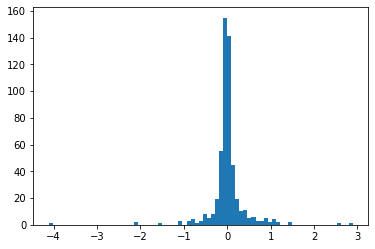

In [268]:
plt.hist(y - y_pred, bins=75);

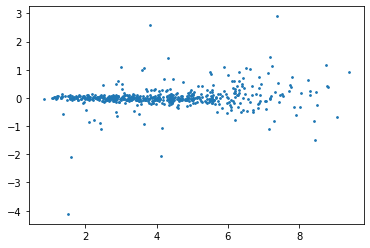

In [272]:
plt.scatter(y, (y - y_pred), s=3);

## Predict on test

In [273]:
def make_test_prediction(distance_model):
    # 1) Fit
    X_train = get_X(train_data_df)
    y_train = train_data_df[['distance']].values[:, 0]
    distance_model.fit(X_train, y_train)
    
    # 2) Predict
    X_test = get_X(test_data_df)
    preds = distance_model.predict(X_test)
    test_data_df_copy = test_data_df.copy()
    test_data_df_copy['distance'] = preds
    solution_df = test_data_df_copy[['image_name', 'distance']]

    # 3) Fill lost test items
    lost_test_items = []
    fill_value = np.mean(preds)

    for file_name in set(test_img_names) - set(solution_df['image_name'].values):
        lost_test_items.append([file_name, fill_value])
    
    print(f'Lost: {len(lost_test_items)} items')
    
    lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])
    solution_df = pd.concat([solution_df, lost_test_items_df])
    
    # 4) Save
    solution_df.to_csv('se_solution.csv', sep=';', index=False)

In [274]:
distance_model = LinearRegression(fit_intercept=False)

make_test_prediction(distance_model)

Lost: 1 items
